In [ ]:
import numpy as np
import torch
import h5py # pour gérer les formats de données utilisés ici

# TP3: Reconnaissance de signaux de communication par apprentissage profond

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb

2 séances de TP sur ce sujet : le 6 novembre (1h00), le 13 novembre (3h).
Le cours du 19 novembre sera partagé en 3 : cours sur la séparation de sources audio / présentation des mini projets et organisation des soutenances / fin de ce TP.<br>
Deadline pour le rendu du TP: 26 novembre 2024, 13h59, par mail à deepetsignal.mva@gmail.com <br>

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook.
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.

## Problématique

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié.

L'émetteur peut provenir de 6 catégories différentes.
Les paramètres différenciant les différentes catégories sont
- le type de modulation
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données
- le débit de la transmission

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0.


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation
électromagnétique comme :
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données).
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

Les objectifs de ce TP sont:

1. Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2. Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html.
3. Qualifier les performances de votre réseau de neurones sur l'ensemble de test via:
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
4. Rapporter les performances de vos architectures à leur complexité, la complexité d'un réseau de neurones étant ici résumé au nombre de paramètres libres qu'il fait intervenir

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation.


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet.
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones".

Surtout privilégiez dans un premier temps la simplicité quitte à complexifier votre approche ensuite pour doper ses performances. Ne restez pas bloqué sur des réseaux qui "mettent trop de temps à apprendre"

## Chargement des données en numpy

Le TP est composé de trois jeux de données :
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

In [2]:
data_path = './train.hdf5'

data = h5py.File(data_path , 'r')

signals = np.array(data['signaux'])
snr =  np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

print(signals.shape)
print(snr.shape)
print(labels_id.shape)

(30000, 2048, 2)
(30000,)
(30000,)


Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [3]:
def get_labels(open_h5_file):
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

### Visualisation des données

Commencez par étudier les données:

    - observez leur taille
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez

Remarque : dans ce TP il n'y a pas beaucoup à gagner à faire du feature engineering

(200, 2048, 2)
(200,)
(200,)


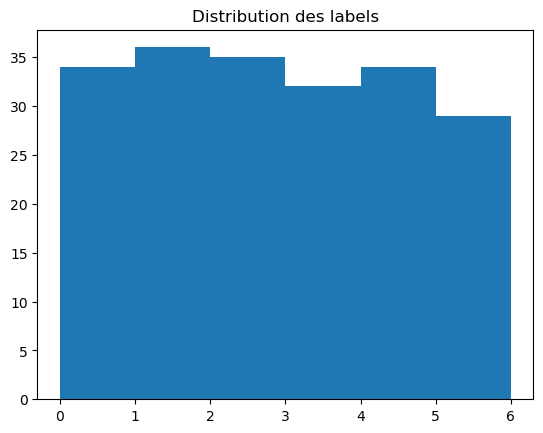

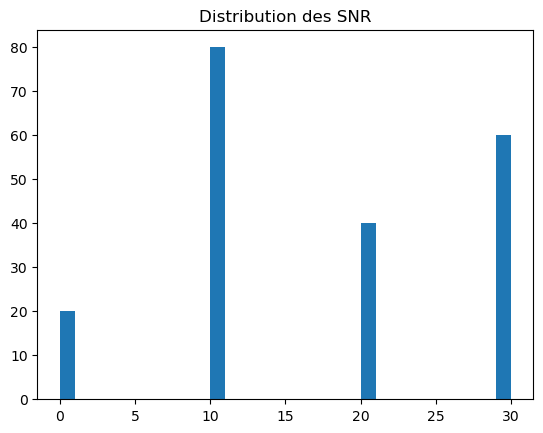

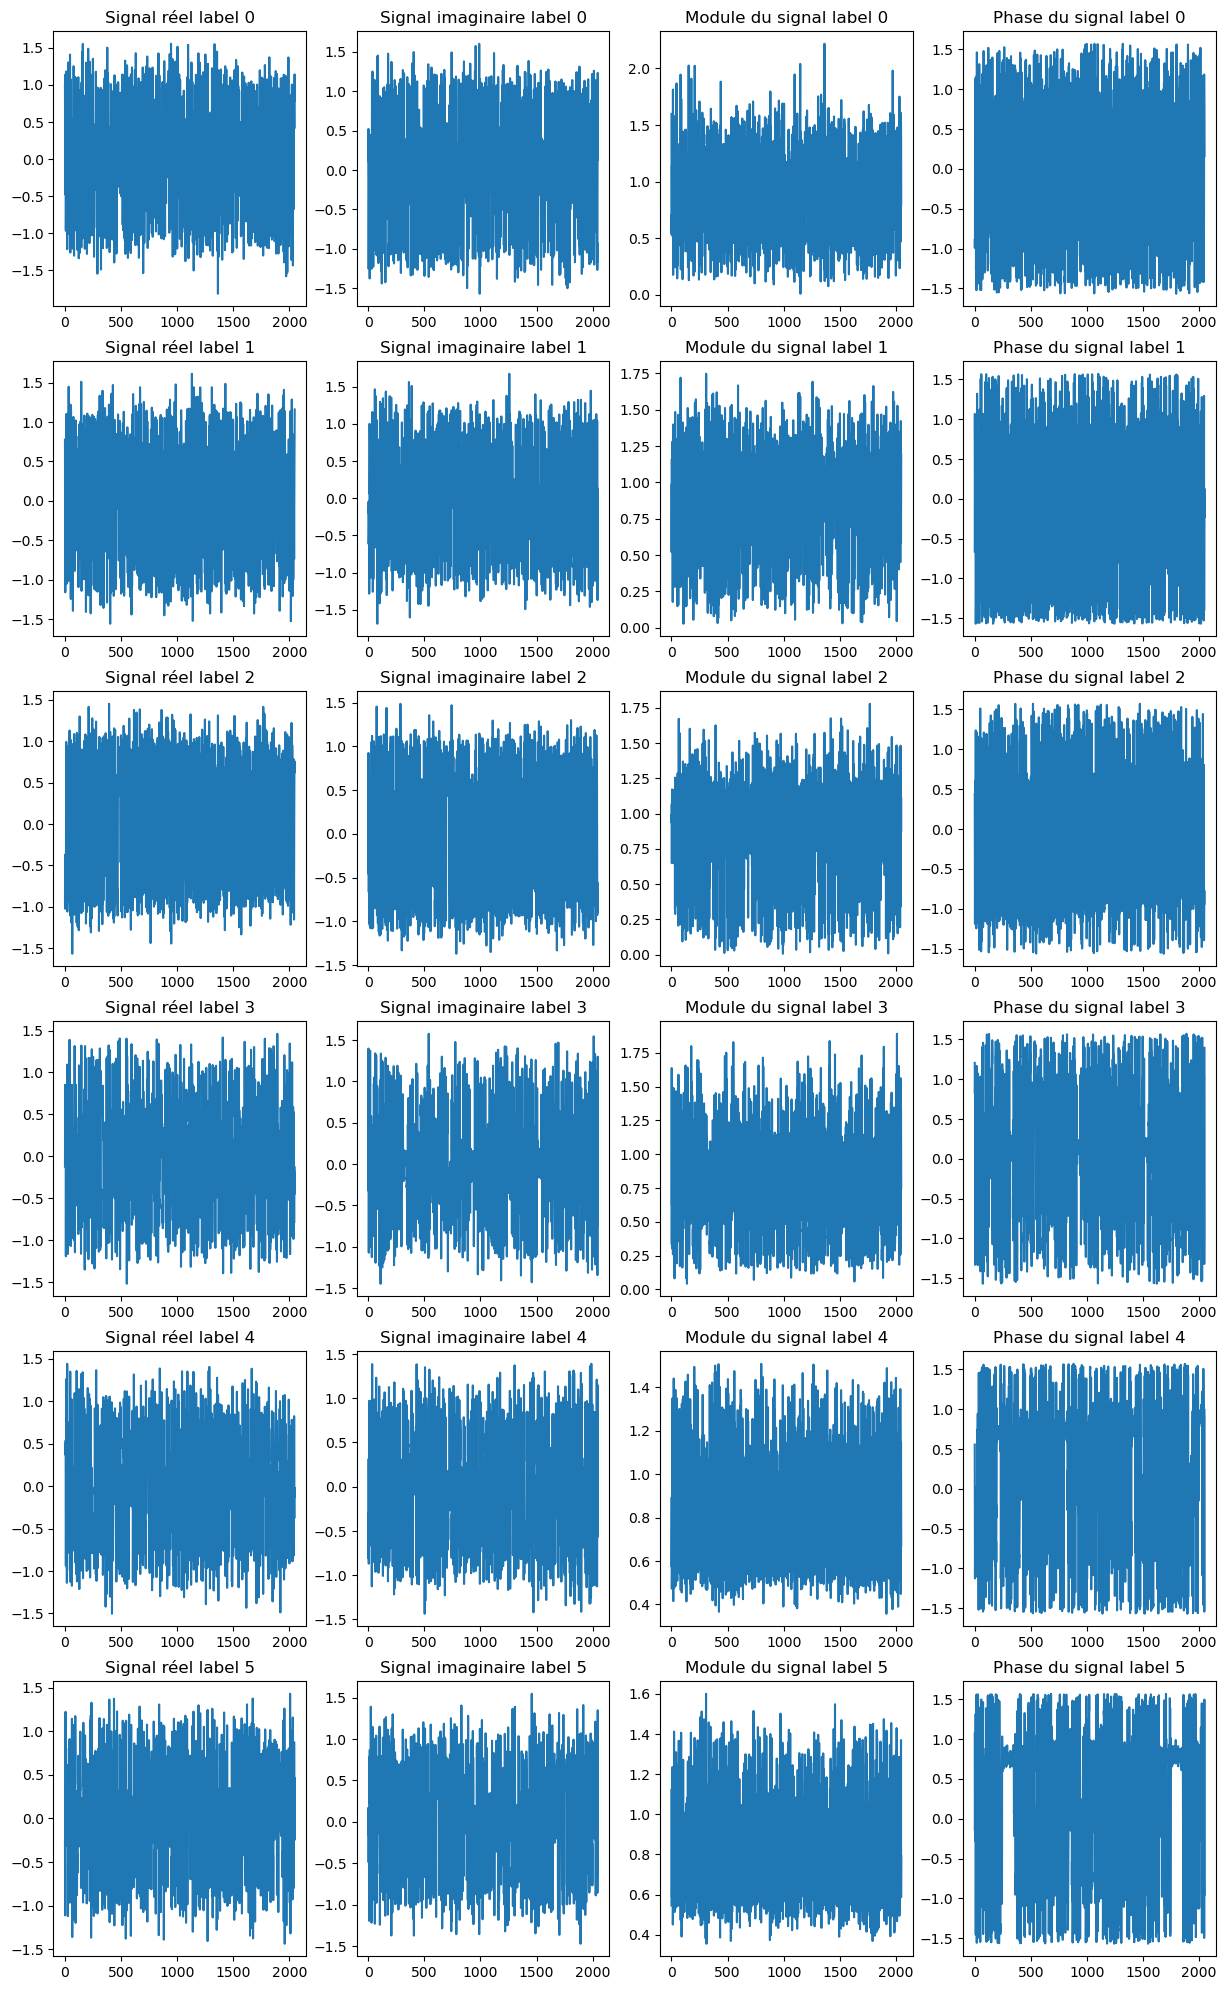

In [4]:
#Chargement des données Samples

data_path = './samples.hdf5'

data = h5py.File(data_path , 'r')

signals = np.array(data['signaux'])
snr =  np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

#Observation taille

print(signals.shape)
print(snr.shape)
print(labels_id.shape)

#Distribution des labels et des SNR dans les données

import matplotlib.pyplot as plt

plt.hist(labels_id, bins=range(7))
plt.title('Distribution des labels')
plt.show()

plt.hist(snr, bins=range(0, 31))
plt.title('Distribution des SNR')
plt.show()

#Affichage de quelques signaux

interest_signals = []
cpt_labels = []

for i in range(200):
    if snr[i] == 30:
        for label in range(6):
            if labels_id[i] == label and label not in cpt_labels:
                interest_signals.append([signals[i], label])
                cpt_labels.append(label)

interest_signals.sort(key=lambda x: x[1])



fig, axs = plt.subplots(len(interest_signals), 4, figsize=(15, 25))
for i in range(len(interest_signals)):
    axs[i, 0].plot(interest_signals[i][0][:,0])
    axs[i, 0].set_title('Signal réel label ' + str(interest_signals[i][1]))
    axs[i, 1].plot(interest_signals[i][0][:,1])
    axs[i, 1].set_title('Signal imaginaire label ' + str(interest_signals[i][1]))
    mod_signal = np.sqrt(interest_signals[i][0][:,0]**2 + interest_signals[i][0][:,1]**2)
    phase_signal = np.arctan(interest_signals[i][0][:,1]/interest_signals[i][0][:,0])
    axs[i, 2].plot(mod_signal)
    axs[i, 2].set_title('Module du signal label ' + str(interest_signals[i][1]))
    axs[i, 3].plot(phase_signal)
    axs[i, 3].set_title('Phase du signal label ' + str(interest_signals[i][1]))


## Chargement des données en Pytorch

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch.
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets :
    - un Dataset qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
    - un Dataloader qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones
    
Un dataset prend la forme
```python
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        ...
    def __len__(self): #retourne le nombre de données dans le dataset
        ...
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, lablel_i), data_i étant un signal et label_i le label associé au signal
        ...
```

Implémentez une classe Dataset pour le dataset considéré ici

In [5]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data):
        data = h5py.File(path_to_data , 'r')
        self.signals = np.array(data['signaux'])
        self.snr =  np.array(data['snr'])
        self.labels = np.array(data['labels'])

    def __len__(self):
        return len(self.signals)

    def __getitem__(self,i):
        signal_i = self.signals[i]
        label_i = self.labels[i]
        return (signal_i, label_i)

Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

In [6]:
dataset = MyDataset(data_path)

Pytorch propose une classe Dataloader qui permet d'échantillonner des batchs de taille fixe à partir d'un dataset.
La cellule suivante donne un exemple d'utilisation

In [7]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset,
                        batch_size=10,
                        shuffle=True
                       )

Testez le dataloader pour différentes valeurs de batch_size

In [8]:
dataloader1 = DataLoader(dataset,
                        batch_size=16,
                        shuffle=True
                       )

dataloader2 = DataLoader(dataset,
                        batch_size=64,
                        shuffle=True
                       )

signals_try, labels_try = next(iter(dataloader2))
print(f"Batch size: {signals_try.shape[0]}")
print (signals_try)
print (labels_try)


Batch size: 64
tensor([[[ 0.5867, -0.4395],
         [ 0.2374, -1.3629],
         [-1.7974, -1.2115],
         ...,
         [ 0.8988, -1.3261],
         [-0.4075, -1.6330],
         [-1.4588,  0.6951]],

        [[ 1.0861, -0.1153],
         [ 0.3136, -0.4154],
         [-0.9355, -0.6136],
         ...,
         [-0.9111,  0.8721],
         [-1.2068,  0.1079],
         [-0.0941, -0.5157]],

        [[-0.4888,  0.4118],
         [ 0.5054,  0.4192],
         [ 1.0026,  0.5637],
         ...,
         [-0.3394,  0.7456],
         [-0.3780,  0.6040],
         [-0.7121, -0.0297]],

        ...,

        [[-0.3550, -1.2525],
         [-0.7175, -1.6450],
         [-0.9641, -0.6761],
         ...,
         [-0.5002, -0.1259],
         [-0.7419,  0.1807],
         [ 0.0154,  0.6645]],

        [[-1.2034,  0.7306],
         [-0.8042,  0.1195],
         [-0.2323, -0.5778],
         ...,
         [ 1.2383,  0.6591],
         [ 1.0614, -0.0448],
         [-0.2346, -0.0804]],

        [[-0.8143,  0

## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier).

Ce modèle doit comporter moins de 10000 paramètres libres.

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

In [9]:
import torch.nn.functional as F

class DumbNN(torch.nn.Module):
    def __init__(self):
        super(DumbNN, self).__init__()
        self.fc1 = torch.nn.Linear(2048*2, 2)
        self.fc2 = torch.nn.Linear(2, 6)

    def forward(self, x):
        x = x.view(x.size(0),-1)
        x = torch.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

Instanciez votre modèle et testez la consistence de ses entrées / sorties vis à vis des données étudiées (test purement fonctionnel, pas besoin de chercher à réaliser un entraînement à ce point).

In [10]:
train_path = './train.hdf5'
train_dataset = MyDataset(train_path)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

test_path = './test.hdf5'
test_dataset = MyDataset(test_path)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

model = DumbNN()
loss = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Estimez par un calcul "théorique" le nombre de paramètres du modèle que vous avez défini et vérifié que le modèle a bien ce nombre de paramètres en pratique par exemple en utilisant la fonction suivante :

In [11]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

In [12]:
count_n_param(model)

8212

## Mise en place de la pipeline d'entraînement

La pipeline d'entrainement consiste à
- charger les données
- les batcher
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires

Un cavnevas d'implémentation pourrait être:

```python
device = 'cpu' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU

model = ...  # vous instanciez ici votre modèle

loss = .... # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = ... # le nombre d'itérations dans l'entrainement

chemin_vers_sauvegarde_model = # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard.

model.to(device) # on place le modèle dans le GPU si nécessaire

for epoch in range(n_epochs):
    
    for batch_x,batch_y in dataloader_train:
        
        batch_x.to(device)
        batch_y.to(device)
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
        
    for batch_x,batch_y in dataloader_valid:
        
        batch_x.to(device)
        batch_y.to(device)
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model, chemin_vers_sauvegarde_model)

```

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_path = 'train.hdf5'
test_path = 'test.hdf5'
samples_path = 'samples.hdf5'
validation_path = 'validation.hdf5'

train_dataset = MyDataset(train_path)
test_dataset = MyDataset(test_path)
samples_dataset = MyDataset(samples_path)
validation_dataset = MyDataset(validation_path)

train_loader = DataLoader(train_dataset)
test_loader = DataLoader(test_dataset)
samples_loader = DataLoader(samples_dataset)
validation_loader = DataLoader(validation_dataset)

In [ ]:
loss = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10

chemin_vers_sauvegarde_model = "reseau_dumb.pth"

model=model.to(device)

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for signaux, labels in train_loader:
        signaux=signaux.to(device)
        labels=labels.to(device).long()
        optimizer.zero_grad()  # remets les gradients à zéro

        outputs = model(signaux)  # prédiction
        loss_val = loss(outputs, labels)  # loss

        loss_val.backward()
        optimizer.step()  # maj des poids

        running_loss += loss_val.item()

    print(f"Époque [{epoch+1}/{n_epochs}], Perte: {running_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), chemin_vers_sauvegarde_model)

Époque [1/10], Perte: 1.8045
Époque [2/10], Perte: 1.7747
Époque [3/10], Perte: 1.7424
Époque [4/10], Perte: 1.7183
Époque [5/10], Perte: 1.6975
Époque [6/10], Perte: 1.6801
Époque [7/10], Perte: 1.6656
Époque [8/10], Perte: 1.6514
Époque [9/10], Perte: 1.6370
Époque [10/10], Perte: 1.6264


Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction
```python
modele = torch.load(...)
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

In [ ]:
model = DumbNN()
model.load_state_dict(torch.load(chemin_vers_sauvegarde_model))

/var/folders/x2/86mdnsk17px0bqlykf2_464h0000gn/T/ipykernel_68403/3467026501.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(chemin_vers_

<All keys matched successfully>

In [ ]:
model = model.to(device)

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for signaux, labels in test_loader:
        signaux = signaux.to(device)
        labels = labels.to(device)
        outputs = model(signaux)
        _, predicted = torch.max(outputs, 1) #prendre classe avec proba la plus élevée
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Précision sur le jeu de test : {100 * correct / total:.2f}%')

Précision sur le jeu de test : 20.36%


In [ ]:
from torchmetrics import Accuracy, Precision, Recall, F1Score

#Initialisation des métriques
accuracy = Accuracy(task="multiclass", num_classes=6).to(device)
precision = Precision(task="multiclass", num_classes=6, average="macro").to(device)
recall = Recall(task="multiclass", num_classes=6, average="macro").to(device)
f1 = F1Score(task="multiclass", num_classes=6, average="macro").to(device)

labels = labels.to(device)

accuracy_value = accuracy(outputs, labels)
precision_value = precision(outputs, labels)
recall_value = recall(outputs, labels)
f1_value = f1(outputs, labels)

# print(f"Accuracy: {accuracy_value}")
# print(f"Precision: {precision_value}")
# print(f"Recall: {recall_value}")
# print(f"F1 Score: {f1_value}")

## Entraînement de réseaux de neurones

Dans cette partie vous définissez une ou plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement.
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Dans un deuxième temps (facultatif), si vous le souhaitez vous pouvez mettre en place des stratégies d'augmentation de données pour améliorer vos résultats. Pour mettre l'augmentation de données en pratique pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch.

### Test de différentes architectures

Modèle 1: Réseau profond linéaire (4xfully connected layers)

In [15]:
class DeepNN(torch.nn.Module):
    def __init__(self):
        super(DeepNN, self).__init__()
        self.fc1 = torch.nn.Linear(2048*2, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 64)
        self.fc4 = torch.nn.Linear(64, 6)

    def forward(self, x):
        x = x.view(x.size(0),-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

Modèle 2: BasicCNN

In [16]:
class basicCNN(torch.nn.Module):
    def __init__(self):
        super(basicCNN, self).__init__()
        # Couches de convolution + max pooling
        self.conv1 = torch.nn.Conv1d(in_channels=2, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool1d(kernel_size=2, stride=2)

        # Couches fully connected pour la classification finale
        self.fc1 = torch.nn.Linear(128 * 256, 512)  # 128 canaux après la dernière couche de convolution et réduction via pooling
        self.fc2 = torch.nn.Linear(512, 6)  # 6 classes d'émetteurs



    def forward(self, x): # x.shape = (batch_size, 2, 2048) (2 canaux et 2048 échantillons)

        x = x.permute(0, 2, 1)
        x = self.pool(F.relu(self.conv1(x)))  # (batch_size, 32, 2048)
        x = self.pool(F.relu(self.conv2(x)))  # (batch_size, 64, 1024)
        x = self.pool(F.relu(self.conv3(x)))  # (batch_size, 128, 512)

        x = x.view(x.size(0), -1)  # (batch_size, 128*256)

        x = F.relu(self.fc1(x))  # (batch_size, 512)
        self.bn_fc = torch.nn.BatchNorm1d(512)
        x = self.fc2(x)  # (batch_size, 6) -> 6 classes

        return F.log_softmax(x, dim=1)

Modèle 3: CNN avec couches récurrentes (GRU) + dropout pour éviter l'overfitting

In [17]:
class CNN_GRU(torch.nn.Module):
    def __init__(self):
        super(CNN_GRU, self).__init__()

        self.conv1 = torch.nn.Conv1d(in_channels=2, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool1d(kernel_size=2, stride=2)

        self.dropout_conv = torch.nn.Dropout(p=0.3) ####

        self.gru = torch.nn.GRU(input_size=128, hidden_size=128, num_layers=1, batch_first=True)

        self.fc1 = torch.nn.Linear(128 * 256, 512)
        self.bn_fc = torch.nn.BatchNorm1d(512)

        self.dropout_fc = torch.nn.Dropout(p=0.5)

        self.fc2 = torch.nn.Linear(512, 6)  #6 classes

    def forward(self, x):  #x.shape = (batch_size, 2, 2048)

        x = x.permute(0, 2, 1)  #(batch_size, 256, 128)  # transpose for GRU (batch_size, seq_len, features)
        x = self.pool(F.relu(self.conv1(x)))  #(batch_size, 32, 1024)
        x = self.dropout_conv(x) ###
        x = self.pool(F.relu(self.conv2(x)))  #(batch_size, 64, 512)
        x = self.dropout_conv(x) ###
        x = self.pool(F.relu(self.conv3(x)))  #(batch_size, 128, 256)
        x = self.dropout_conv(x) ###

        x = x.permute(0, 2, 1) # (batch_size, 256, 128)  #transpose back for GRU (batch_size, seq_len, features)

        x, _ = self.gru(x)  #Output shape: (batch_size, 256, 128), recurrent layer

        x = x.contiguous().view(x.size(0), -1)  #(batch_size, 128 * 256) #to flatten before the fc layers

        x = F.relu(self.fc1(x))  #(batch_size, 512)

        x = self.bn_fc(x) ###
        x = self.dropout_fc(x)###

        x = self.fc2(x)  #(batch_size, 6)

        return F.log_softmax(x, dim=1)

Modèle 4: ResNet (+ on ajoute du dropout pour éviter l'overfitting)

In [18]:
class ResNet(torch.nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        self.init_conv = torch.nn.Conv1d(in_channels=2, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.init_bn = torch.nn.BatchNorm1d(64)

        self.res_block1 = torch.nn.Sequential(
            torch.nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3), ####
            torch.nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm1d(64)
        )

        self.res_block2 = torch.nn.Sequential(
            torch.nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm1d(128)
        )

        self.global_pool = torch.nn.AdaptiveAvgPool1d(1)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(128, 6),  #6 classes
            torch.nn.Dropout(0.5)  ###
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch_size, channels, sequence_length)

        x = F.relu(self.init_bn(self.init_conv(x)))  # (batch_size, 64, sequence_length)

        residual = x
        x = self.res_block1(x)  # (batch_size, 64, sequence_length)
        x += residual
        x = F.relu(x)

        residual = F.avg_pool1d(x, kernel_size=2)  #downsample for dimension match
        x = F.avg_pool1d(x, kernel_size=2)  #downsample the main path
        x = self.res_block2(x)  # (batch_size, 128, sequence_length // 2)
        residual = torch.nn.functional.pad(residual, (0, 0, 0, 64))
        x += residual
        x = F.relu(x)

        x = self.global_pool(x)  # (batch_size, 128, 1)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 128)
        x = self.fc(x)  # (batch_size, 6)

        return F.log_softmax(x, dim=1)

Modèle 5: Convolutions en blocs

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, use_dropout=False, dropout_prob=0.5):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=False)
        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        if self.use_dropout:
            x = self.dropout(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_dropout=False, dropout_prob=0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, use_dropout=use_dropout, dropout_prob=dropout_prob)
        self.conv2 = ConvBlock(out_channels, out_channels, use_dropout=use_dropout, dropout_prob=dropout_prob)
        self.match_dimensions = (in_channels != out_channels)
        self.relu = nn.ReLU(inplace=False)

        if self.match_dimensions:
            self.residual_connection = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        else:
            self.residual_connection = nn.Identity()

    def forward(self, x):
        residual = self.residual_connection(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x + residual
        return self.relu(x)
        #return x

class CustomResNet(nn.Module):
    def __init__(self, input_channels=2, num_classes=6, num_blocks=[2, 2, 2], block_channels=[64, 128, 256]): #pour nous, input_channels=2 pour signal IQ, num_classes=6 en sortie, on doit avoir len(num_blocks)==len(block_channels)
        super(CustomResNet, self).__init__()

        self.init_conv = ConvBlock(input_channels, block_channels[0], kernel_size=3, stride=1, padding=1)

        layers = []
        for i in range(len(num_blocks)):
            for j in range(num_blocks[i]):
                in_ch = block_channels[i - 1] if i > 0 and j == 0 else block_channels[i]
                layers.append(ResidualBlock(in_ch, block_channels[i]))
        self.residual_layers = nn.Sequential(*layers)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(block_channels[-1], num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.init_conv(x)
        x = self.residual_layers(x)
        x = self.global_pool(x)  # (batch_size, channels, 1)
        x = x.view(x.size(0), -1)  #flatten pour la couche fully connected
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [20]:
#### test model

import torch
import torch.nn as nn

# Bloc ResNet (convolution avec skip connection)
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

        # Pour les connexions résiduelles, on utilise une couche de convolution 1x1 pour adapter les dimensions si nécessaire
        self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        out += self.shortcut(x)  # Connexion résiduelle
        out = self.relu(out)
        return out

class CNN_LSTM_ResNet_Model(nn.Module):
    def __init__(self, input_size=2048, hidden_size=128, num_classes=6, num_layers=1):
        super(CNN_LSTM_ResNet_Model, self).__init__()

        # Couches ResNet
        self.resnet_block1 = ResNetBlock(2, 32)  # 2 canaux (réel, imaginaire)
        self.resnet_block2 = ResNetBlock(32, 64)
        self.resnet_block3 = ResNetBlock(64, 128)

        # Couches LSTM
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Couches Fully Connected (FC)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Passer à travers les blocs ResNet
        x = x.permute(0, 2, 1)

        x = self.resnet_block1(x)
        x = self.resnet_block2(x)
        x = self.resnet_block3(x)

        # Mettre en forme pour LSTM (N, T, D) => (batch_size, sequence_length, feature_size)
        x = x.permute(0, 2, 1)  # Changer la forme pour LSTM

        # Passer à travers le LSTM
        lstm_out, (hn, cn) = self.lstm(x)  # On récupère la sortie du LSTM (lstm_out)

        # Utiliser la dernière sortie cachée de l'LSTM
        lstm_out = hn[-1]  # Dernière sortie cachée

        # Passer à travers les couches Fully Connected
        x = torch.relu(self.fc1(lstm_out))
        #x = self.fc2(x)
        x = torch.log_softmax(self.fc2(x), dim=1)

        return x

### Pipeline d'entraînement (et de test)

In [21]:
def train_model(model, batch_size, loss_function, learning_rate, n_epochs, chemin_vers_sauvegarde_model):
    train_path = './train.hdf5'
    train_dataset = MyDataset(train_path)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

    validation_path = './validation.hdf5'
    validation_dataset = MyDataset(validation_path)
    validation_loader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = False)    #On ne veut pas mélanger pour que ça reste reproductible

    loss = loss_function
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    # Initialisation des métriques
    accuracy_train = Accuracy(task="multiclass", num_classes=6).to(device)
    precision_train = Precision(task="multiclass", num_classes=6, average="macro").to(device)
    recall_train = Recall(task="multiclass", num_classes=6, average="macro").to(device)
    accuracy_val = Accuracy(task="multiclass", num_classes=6).to(device)
    precision_val = Precision(task="multiclass", num_classes=6, average="macro").to(device)
    recall_val = Recall(task="multiclass", num_classes=6, average="macro").to(device)
    T_loss_train = []
    T_loss_val = []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        running_loss_val = 0.0
        for signaux, labels in train_loader:
            signaux = signaux.to(device)
            labels = labels.to(device).long()
            optimizer.zero_grad()

            outputs = model(signaux)
            loss_train = loss(outputs, labels)

            loss_train.backward()
            optimizer.step()

            running_loss += loss_train.item()
            accuracy_train.update(outputs, labels)
            precision_train.update(outputs, labels)
            recall_train.update(outputs, labels)

        print(f"Epoch [{epoch+1}/{n_epochs}], Perte: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy_train.compute():.4f}, Precision: {precision_train.compute():.4f}, Recall: {recall_train.compute():.4f}")
        T_loss_train.append(running_loss/len(train_loader))

        for signaux, labels in validation_loader:
            signaux = signaux.to(device)
            labels = labels.to(device).long()

            with torch.no_grad():
                outputs = model(signaux)
                loss_val = loss(outputs, labels)
                running_loss_val += loss_val.item()
                accuracy_val.update(outputs, labels)
                precision_val.update(outputs, labels)
                recall_val.update(outputs, labels)

        print(f"Epoch Validation [{epoch+1}/{n_epochs}], Perte: {running_loss_val/len(validation_loader):.4f},Accuracy: {accuracy_val.compute():.4f},Precision: {precision_val.compute():.4f},Recall: {recall_val.compute():.4f}\n")
        T_loss_val.append(running_loss_val/len(validation_loader))

        #réinitialisation des métriques pour la prochaine époque
        accuracy_train.reset()
        precision_train.reset()
        recall_train.reset()
        accuracy_val.reset()
        precision_val.reset()
        recall_val.reset()

    plt.plot([i for i in range(n_epochs)], T_loss_train, label = 'Train')
    plt.plot([i for i in range(n_epochs)], T_loss_val, label = 'Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    torch.save(model.state_dict(), chemin_vers_sauvegarde_model)



def test_model(model, batch_size, chemin_vers_sauvegarde_model):
    test_path = './test.hdf5'
    test_dataset = MyDataset(test_path)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

    model = model.to(device)
    state_dict = torch.load(chemin_vers_sauvegarde_model, map_location=device)
    model.load_state_dict(state_dict)

    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for signaux, labels in test_loader:
            signaux=signaux.to(device)
            labels=labels.to(device)
            outputs = model(signaux)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Précision sur le jeu de test : {100 * correct / total:.2f}%')

### Entraînement des différents modèles

Epoch [1/10], Perte: 0.8974, Accuracy: 0.5061, Precision: 0.5039, Recall: 0.5053
Epoch Validation [1/10], Perte: 0.6555,Accuracy: 0.5798,Precision: 0.5000,Recall: 0.5900

Epoch [2/10], Perte: 0.6488, Accuracy: 0.6029, Precision: 0.5961, Recall: 0.6023
Epoch Validation [2/10], Perte: 0.6510,Accuracy: 0.5904,Precision: 0.5167,Recall: 0.5864

Epoch [3/10], Perte: 0.6354, Accuracy: 0.6193, Precision: 0.6116, Recall: 0.6187
Epoch Validation [3/10], Perte: 0.6360,Accuracy: 0.5989,Precision: 0.5798,Recall: 0.5922

Epoch [4/10], Perte: 0.6041, Accuracy: 0.6627, Precision: 0.6580, Recall: 0.6623
Epoch Validation [4/10], Perte: 0.6748,Accuracy: 0.5818,Precision: 0.5783,Recall: 0.5904

Epoch [5/10], Perte: 0.5000, Accuracy: 0.7445, Precision: 0.7433, Recall: 0.7442
Epoch Validation [5/10], Perte: 0.7770,Accuracy: 0.5842,Precision: 0.5825,Recall: 0.5862

Epoch [6/10], Perte: 0.3435, Accuracy: 0.8415, Precision: 0.8412, Recall: 0.8414
Epoch Validation [6/10], Perte: 0.9852,Accuracy: 0.5979,Precisio

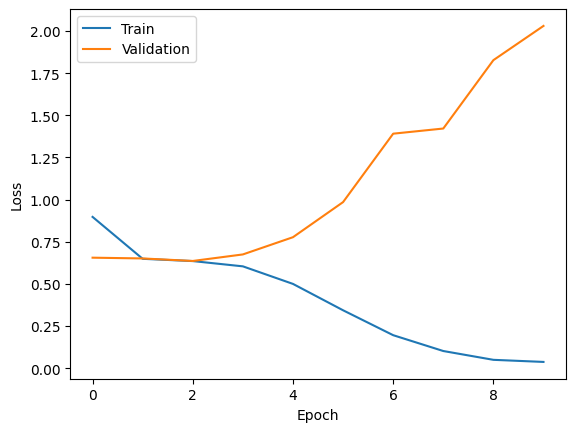

In [ ]:
train_model(basicCNN(), 32, torch.nn.NLLLoss(), 0.001, 10, "reseau_basicCNN.pth")

On observe qu'il y a de l'overfitting.

Epoch [1/15], Perte: 1.0268, Accuracy: 0.4601, Precision: 0.4569, Recall: 0.4601
Epoch Validation [1/15], Perte: 0.7341,Accuracy: 0.5777,Precision: 0.5619,Recall: 0.5826

Epoch [2/15], Perte: 0.7637, Accuracy: 0.5798, Precision: 0.5738, Recall: 0.5793
Epoch Validation [2/15], Perte: 0.7125,Accuracy: 0.5893,Precision: 0.5861,Recall: 0.5895

Epoch [3/15], Perte: 0.7159, Accuracy: 0.5868, Precision: 0.5807, Recall: 0.5863
Epoch Validation [3/15], Perte: 0.6842,Accuracy: 0.5885,Precision: 0.5993,Recall: 0.5950

Epoch [4/15], Perte: 0.7074, Accuracy: 0.5899, Precision: 0.5844, Recall: 0.5894
Epoch Validation [4/15], Perte: 0.7033,Accuracy: 0.5912,Precision: 0.6117,Recall: 0.5897

Epoch [5/15], Perte: 0.6887, Accuracy: 0.6021, Precision: 0.5973, Recall: 0.6016
Epoch Validation [5/15], Perte: 0.7201,Accuracy: 0.5918,Precision: 0.5871,Recall: 0.5972

Epoch [6/15], Perte: 0.6694, Accuracy: 0.6031, Precision: 0.5977, Recall: 0.6025
Epoch Validation [6/15], Perte: 0.6457,Accuracy: 0.6231,Precisio

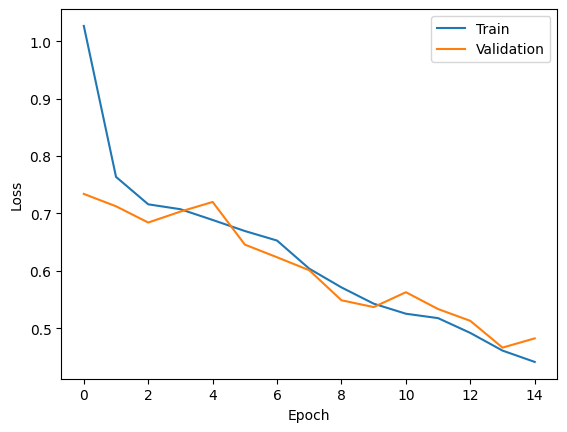

In [ ]:
train_model(CNN_GRU(), 32, torch.nn.NLLLoss(), 0.001, 15, "reseau_CNN_GRU.pth")

In [ ]:
train_model(ResNet(), 32, torch.nn.NLLLoss(), 0.001, 15, "reseau_ResNet.pth")

Epoch [1/15], Perte: 1.2651, Accuracy: 0.4503, Precision: 0.4606, Recall: 0.4484
Epoch Validation [1/15], Perte: 1.1266,Accuracy: 0.5036,Precision: 0.5118,Recall: 0.5043



Epoch [1/15], Perte: 0.6862, Accuracy: 0.6290, Precision: 0.6279, Recall: 0.6283
Epoch Validation [1/15], Perte: 0.5385,Accuracy: 0.6830,Precision: 0.6930,Recall: 0.6856

Epoch [2/15], Perte: 0.5184, Accuracy: 0.7019, Precision: 0.7004, Recall: 0.7013
Epoch Validation [2/15], Perte: 0.5060,Accuracy: 0.7027,Precision: 0.7086,Recall: 0.7076

Epoch [3/15], Perte: 0.4967, Accuracy: 0.7055, Precision: 0.7053, Recall: 0.7047
Epoch Validation [3/15], Perte: 0.4718,Accuracy: 0.7135,Precision: 0.7042,Recall: 0.7152

Epoch [4/15], Perte: 0.4781, Accuracy: 0.7101, Precision: 0.7089, Recall: 0.7092
Epoch Validation [4/15], Perte: 0.4619,Accuracy: 0.7128,Precision: 0.7407,Recall: 0.7131

Epoch [5/15], Perte: 0.4840, Accuracy: 0.7053, Precision: 0.7059, Recall: 0.7046
Epoch Validation [5/15], Perte: 0.4778,Accuracy: 0.7141,Precision: 0.7489,Recall: 0.7127

Epoch [6/15], Perte: 0.4713, Accuracy: 0.7080, Precision: 0.7095, Recall: 0.7070
Epoch Validation [6/15], Perte: 0.4625,Accuracy: 0.7131,Precisio

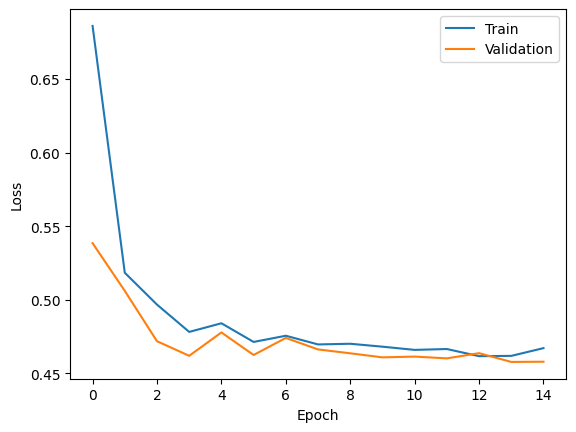

In [ ]:
#torch.autograd.set_detect_anomaly(True)

train_model(CustomResNet(), 32, torch.nn.NLLLoss(), 0.001, 15, "reseau_CustomResNet.pth")

Epoch [1/10], Perte: 1.4867, Accuracy: 0.3018, Precision: 0.3036, Recall: 0.3004
Epoch Validation [1/10], Perte: 1.1592,Accuracy: 0.4150,Precision: 0.3923,Recall: 0.4101

Epoch [2/10], Perte: 0.8412, Accuracy: 0.5385, Precision: 0.5366, Recall: 0.5377
Epoch Validation [2/10], Perte: 0.6510,Accuracy: 0.5772,Precision: 0.5111,Recall: 0.5876

Epoch [3/10], Perte: 0.6880, Accuracy: 0.5746, Precision: 0.5706, Recall: 0.5737
Epoch Validation [3/10], Perte: 0.6605,Accuracy: 0.5822,Precision: 0.5566,Recall: 0.5790

Epoch [4/10], Perte: 0.6416, Accuracy: 0.5810, Precision: 0.5758, Recall: 0.5803
Epoch Validation [4/10], Perte: 0.6362,Accuracy: 0.5822,Precision: 0.5081,Recall: 0.5870

Epoch [5/10], Perte: 0.6446, Accuracy: 0.5880, Precision: 0.5838, Recall: 0.5869
Epoch Validation [5/10], Perte: 0.6322,Accuracy: 0.5780,Precision: 0.5979,Recall: 0.5853

Epoch [6/10], Perte: 0.6385, Accuracy: 0.5822, Precision: 0.5782, Recall: 0.5812
Epoch Validation [6/10], Perte: 0.6355,Accuracy: 0.5783,Precisio

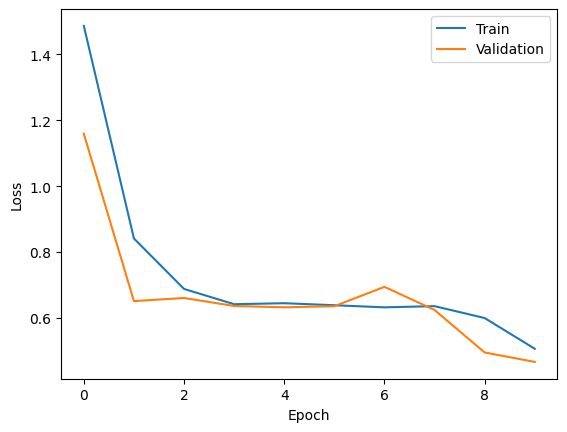

In [ ]:
train_model(CNN_LSTM_ResNet_Model(), 32, torch.nn.NLLLoss(), 0.001, 15, "reseau_CNN_LSTM_ResNet.pth")

In [ ]:
## Data Augmentation

# On peut ajouter du bruit aux signaux pour augmenter la taille du jeu de données

def add_noise(signal, snr):
    signal_power = np.mean(signal[:,0]**2 + signal[:,1]**2)
    noise_power = signal_power / (10**(snr/10))
    real_noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    imag_noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    return [signal[:,0] + real_noise[:,0], signal[:,1] + imag_noise[:,1]]


## Débruitage des signaux par le filtre de Wiener

# Afin de corriger les signaux bruités par le bruit gaussien, on peut utiliser le filtre de Wiener

from scipy.signal import welch

def wiener_filter_with_snr(signal, snr, fs=1.0):
    """
    Apply Wiener filtering to denoise a 2-channel signal (real + imaginary) using SNR.

    Parameters:
        signal (ndarray): Noisy signal with shape (2, N) [real, imaginary].
        snr (float): Signal-to-Noise Ratio (linear scale, not dB).
        fs (float): Sampling frequency.

    Returns:
        denoised_signal (ndarray): Denoised signal with shape (2, N).
    """
    # Split into real and imaginary parts
    real, imag = signal[:,0], signal[:,1]

    # Estimate Signal Power (time-domain)
    signal_power_real = np.mean(real**2)
    signal_power_imag = np.mean(imag**2)

    # Compute Noise Power using SNR
    noise_power_real = signal_power_real / snr
    noise_power_imag = signal_power_imag / snr

    # Apply FFT to both channels
    fft_real = np.fft.fft(real)
    fft_imag = np.fft.fft(imag)

    # Compute PSD using Welch's method
    f, psd_real = welch(real, fs=fs)
    _, psd_imag = welch(imag, fs=fs)

    # Estimate clean signal PSD
    psd_clean_real = np.maximum(psd_real - noise_power_real, 1e-10)  # Avoid division by zero
    psd_clean_imag = np.maximum(psd_imag - noise_power_imag, 1e-10)

    # Compute Wiener filter
    wiener_filter_real = psd_clean_real / (psd_clean_real + noise_power_real)
    wiener_filter_imag = psd_clean_imag / (psd_clean_imag + noise_power_imag)

    # Apply filter in frequency domain
    filtered_fft_real = fft_real * wiener_filter_real
    filtered_fft_imag = fft_imag * wiener_filter_imag

    # Transform back to time domain
    denoised_real = np.fft.ifft(filtered_fft_real).real
    denoised_imag = np.fft.ifft(filtered_fft_imag).real

    # Combine the denoised real and imaginary parts
    denoised_signal = np.vstack([denoised_real, denoised_imag])

    return denoised_signal

## Synthèse de résultats

Une fois que votre ou vos réseaux sont entrainés vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test sans oublier de mesurer également la complexité de chaque approche en termes de nombre de paramètres. Si vous avez testé des approches qui vous semblent avoir échoué vous pouvez rédiger un petit paragraphe pour expliquer votre analyse de cet échec.

In [27]:
test_model(basicCNN(), 32, 'basic_CNN.pth')

C:\Users\franc\AppData\Local\Temp\ipykernel_7228\2430372870.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(chemin_vers_sauvegarde_model, map_lo

Précision sur le jeu de test : 15.36%


In [ ]:
count_n_param(basicCNN())

16811942

In [ ]:
test_model(CNN_GRU(), 32, "reseau_CNN_GRU.pth")

/var/folders/x2/86mdnsk17px0bqlykf2_464h0000gn/T/ipykernel_68403/2430372870.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(chemin_vers_sauvegar

Précision sur le jeu de test : 60.49%


In [ ]:
count_n_param(CNN_GRU())

16912038

In [ ]:
test_model(ResNet(), 32, "reseau_ResNet.pth")

/var/folders/x2/86mdnsk17px0bqlykf2_464h0000gn/T/ipykernel_68403/2430372870.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(chemin_vers_sauvegar

Précision sur le jeu de test : 73.79%


In [ ]:
count_n_param(ResNet())

100358

In [ ]:
test_model(CustomResNet(), 32, "reseau_CustomResNet.pth")

<ipython-input-40-9fe9dea48bf6>:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(chemin_vers_sauvegarde_model)


Précision sur le jeu de test : 72.24%


In [28]:
count_n_param(CustomResNet())

955910

In [ ]:
test_model(CNN_LSTM_ResNet_Model(), 32, "reseau_CNN_LSTM_ResNet.pth")

<ipython-input-40-9fe9dea48bf6>:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(chemin_vers_sauvegarde_model)


Précision sur le jeu de test : 71.09%


In [29]:
count_n_param(CNN_LSTM_ResNet_Model())

247142

## Test des modèles en fonction du SNR

C:\Users\franc\AppData\Local\Temp\ipykernel_7228\3176906566.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(chemin_vers_sauvegarde_model, map_lo

Précision pour SNR = 0 dB : 73.20%
Précision pour SNR = 10 dB : 74.03%
Précision pour SNR = 20 dB : 72.18%
Précision pour SNR = 30 dB : 74.63%


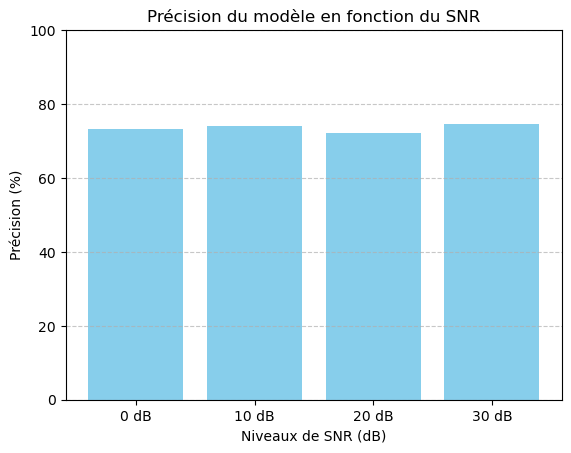

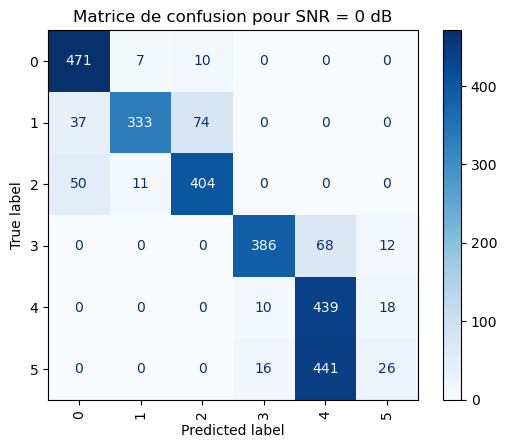

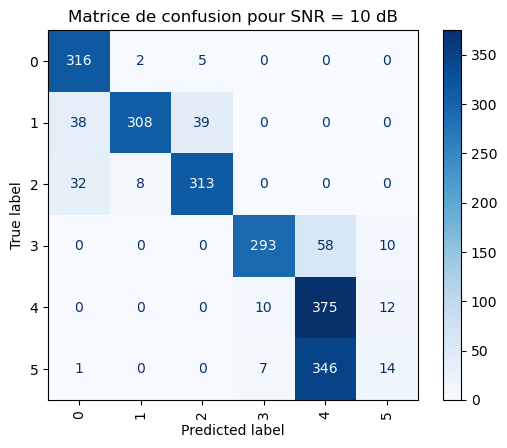

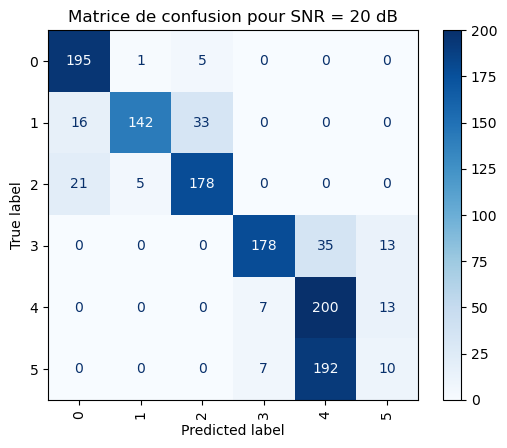

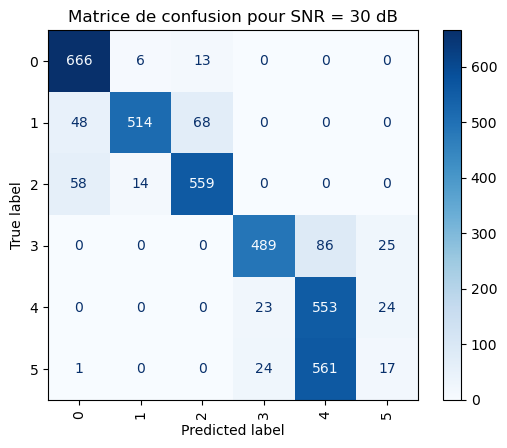

In [ ]:
# Adaptation de la fonction de test du modèle en segmentant par niveau du SNR

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test_model_snr(model, batch_size, chemin_vers_sauvegarde_model):
    test_path = './test.hdf5'
    test_dataset = MyDataset(test_path)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    state_dict = torch.load(chemin_vers_sauvegarde_model, map_location=device)
    model.load_state_dict(state_dict)

    model.eval()

    snr_levels = [0, 10, 20, 30]  # Les niveaux de SNR
    correct_by_snr = {snr: 0 for snr in snr_levels}
    total_by_snr = {snr: 0 for snr in snr_levels}
    predictions_by_snr = {snr: [] for snr in snr_levels}
    labels_by_snr = {snr: [] for snr in snr_levels}
    accuracies = []

    with torch.no_grad():
        for signaux, labels in test_loader:
            signaux = signaux.to(device)
            labels = labels.to(device)

            outputs = model(signaux)
            _, predicted = torch.max(outputs, 1)

            # Récupérer les SNR pour ces signaux
            snr_values = test_dataset.snr[:len(signaux)]

            # Comparer les prédictions pour chaque signal
            for i in range(len(signaux)):
                snr = snr_values[i]
                label = labels[i]
                pred = predicted[i]

                if snr in snr_levels:
                    total_by_snr[snr] += 1
                    correct_by_snr[snr] += (pred == label).item()
                    predictions_by_snr[snr].append(pred.cpu().item())
                    labels_by_snr[snr].append(label.cpu().item())

    # Affichage des résultats pour chaque niveau de SNR
    for snr in snr_levels:
        if total_by_snr[snr] > 0:
            accuracy = 100 * correct_by_snr[snr] / total_by_snr[snr]
            accuracies.append(accuracy)
            print(f'Précision pour SNR = {snr} dB : {accuracy:.2f}%')
        else:
            print(f'Pas d\'échantillons pour SNR = {snr} dB')

    # Tracer l'histogramme
    plt.bar([str(snr) + " dB" for snr in snr_levels], accuracies, color='skyblue')
    plt.title('Précision du modèle en fonction du SNR')
    plt.xlabel('Niveaux de SNR (dB)')
    plt.ylabel('Précision (%)')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Affichage des matrices de confusion
    for snr in snr_levels:
        if len(labels_by_snr[snr]) > 0:
            cm = confusion_matrix(labels_by_snr[snr], predictions_by_snr[snr])
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_dataset.labels))
            disp.plot(cmap='Blues', xticks_rotation='vertical')
            plt.title(f'Matrice de confusion pour SNR = {snr} dB')
            plt.show()


test_model_snr(ResNet(), 32, "reseau_ResNet.pth")

C:\Users\franc\AppData\Local\Temp\ipykernel_7228\3176906566.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(chemin_vers_sauvegarde_model, map_lo

Précision pour SNR = 0 dB : 70.10%
Précision pour SNR = 10 dB : 69.91%
Précision pour SNR = 20 dB : 70.26%
Précision pour SNR = 30 dB : 72.85%


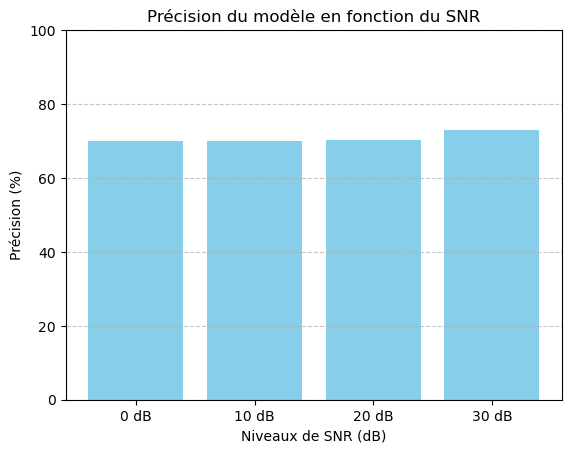

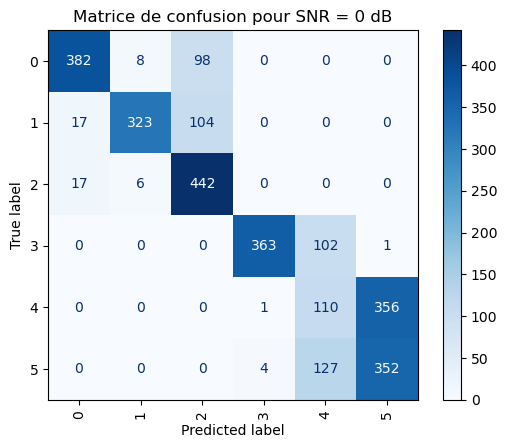

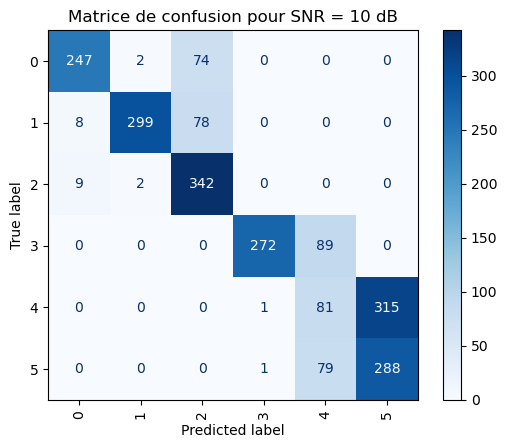

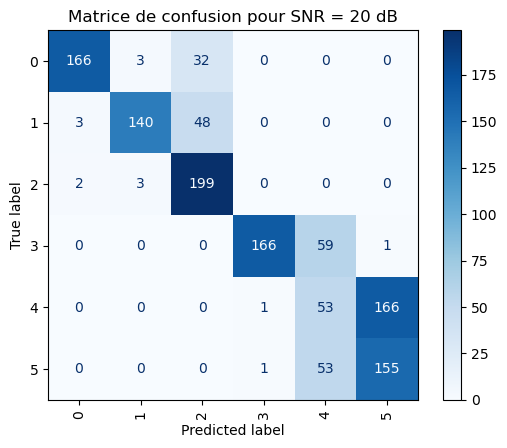

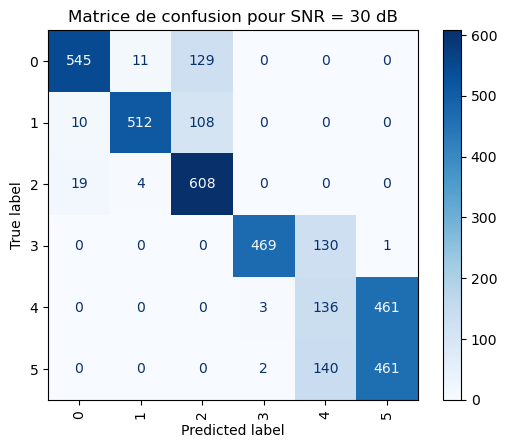

In [35]:
test_model_snr(CustomResNet(), 32, "reseau_CustomResNet.pth")

C:\Users\franc\AppData\Local\Temp\ipykernel_7228\3176906566.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(chemin_vers_sauvegarde_model, map_lo

Précision pour SNR = 0 dB : 60.29%
Précision pour SNR = 10 dB : 63.10%
Précision pour SNR = 20 dB : 59.39%
Précision pour SNR = 30 dB : 59.48%


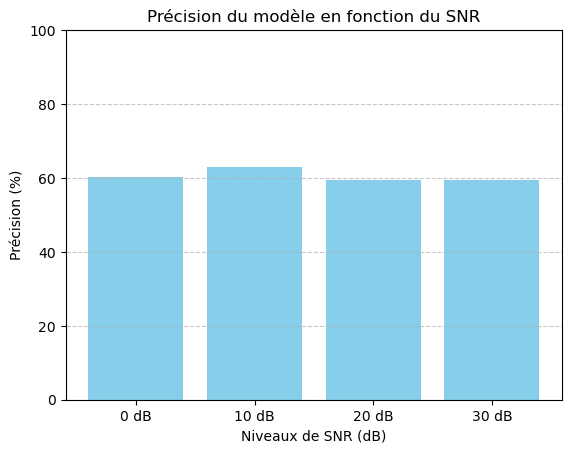

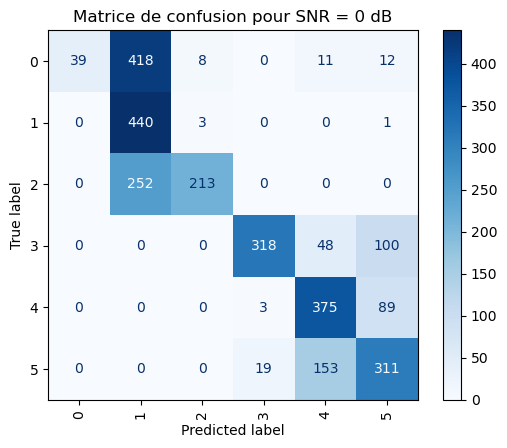

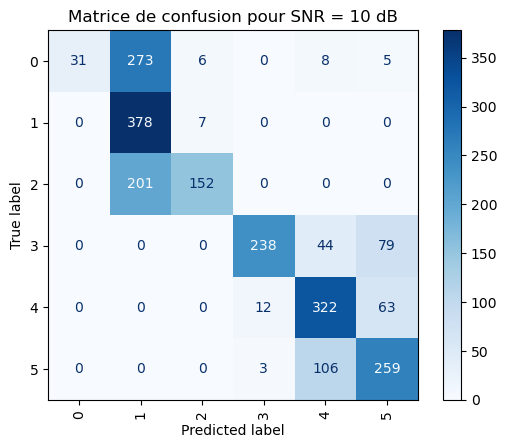

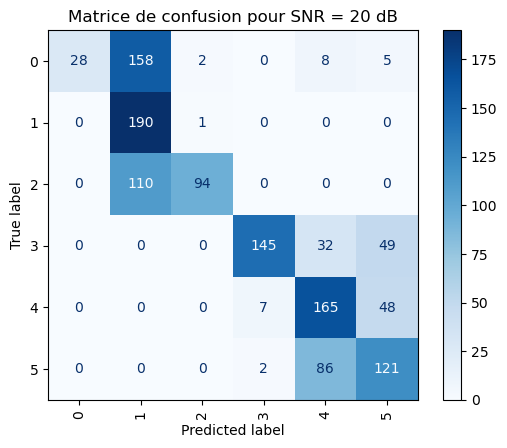

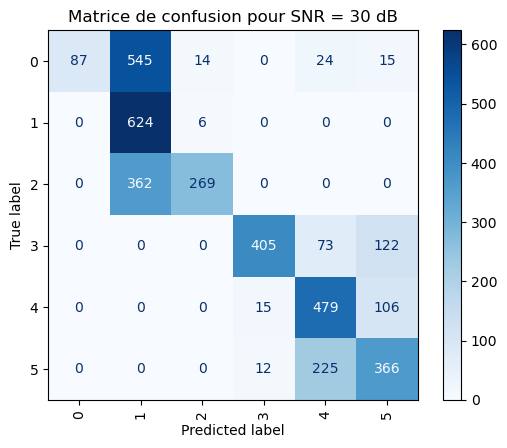

In [36]:
test_model_snr(CNN_GRU(), 32, "reseau_CNN_GRU.pth")

# Conclusion

Par ces résultats, on constate tout d'abord, avec quelque surprise, que le SNR ne joue vraisemblablement pas un rôle important dans la classification. En effet l'histogramme montre que le modèle est aussi efficace pour chaque niveau de bruit.
Ensuite on visualise les matrices de confusion et on observe que certaines classes ne sont pas différenciées correctement. Pour ResNet les classes 4 et 5 sont même totalement confondues, alors que les 4 autres sont globalement bien détermiénes. C'est donc, a priori, le modèle plus que les données qui pose problème. 
Pourtant lorsque l'on reconduit ces tests pour les autres modèles étudiés, on observe le même phénomène, parfois même encore plus important.
On peut néanmoins relever de possibles pistes d'amélioration : 
- Peut-être que le dropout est trop fort (pour CustomResNet et CNN8GRU p_dropout = 0.5 et pour ResNet 'standard' p_dropout = 0.3).
- On peut également implémenter des techniques de Data Augmentation, comme le bruit gaussien. Couplé avec la diminution du dropout, cela peut augmenter les capacités de généralisation du modèle sans produire plus d'overfitting.
- Cependant, si l'on ajoute du bruit, le SNR risque d'augmenter et de rendre l'étude du signal plus compliquée. On peut alors implémenter un filtre de Wiener afin de corriger ce bruit.